In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal
from darts.models import NaiveDrift
from darts.metrics import rmse
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [2]:
import pandas as pd
import numpy as np
from darts import TimeSeries
    
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('el_price.csv', sep = ';')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])
    
# Interpolate missing values in the 'price' column using linear method
df_el['price'].interpolate(method='linear', inplace=True)

ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=True, freq=None)

In [6]:
# Create training and validation sets:
train, test = ts.split_after(pd.Timestamp("01.05.2023 00:00"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
test_transformed = transformer.transform(test)
series_transformed = transformer.transform(ts)

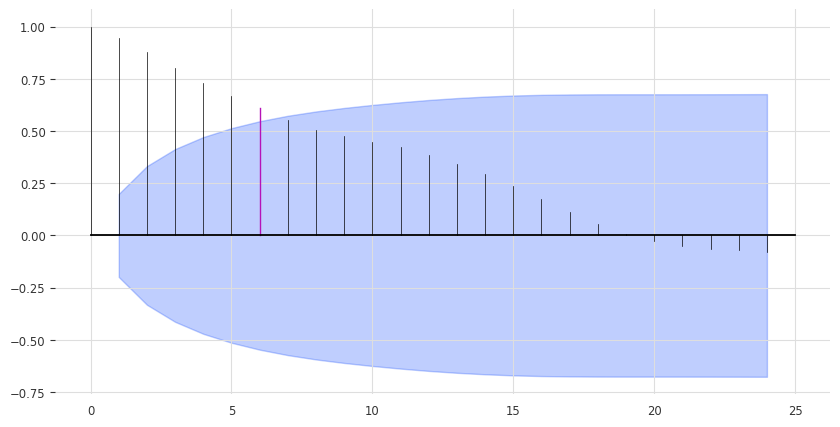

In [8]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_transformed, m=6, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(train, m=6, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

### our data has not seasonality data. 

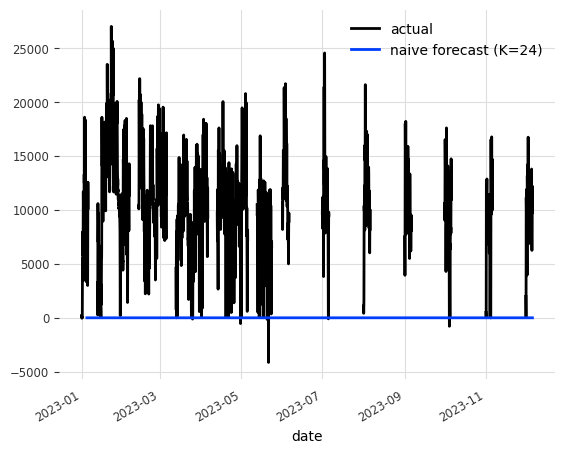

In [12]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=24) # k: 
seasonal_model.fit(train_transformed)
seasonal_forecast = seasonal_model.predict(len(test_transformed))

ts.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=24)")

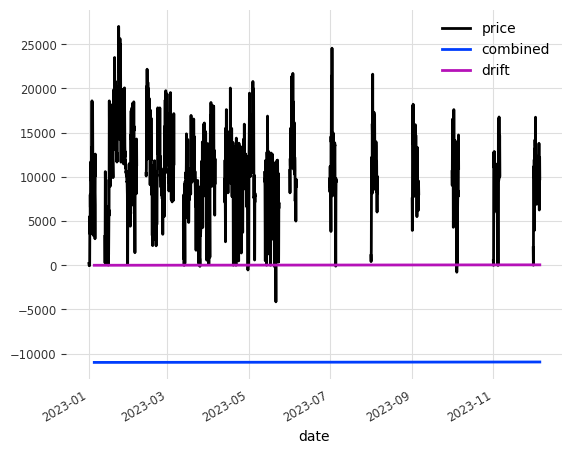

In [13]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train_transformed)
drift_forecast = drift_model.predict(len(test_transformed))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

ts.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [11]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(ts))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(ts, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing() obtains RMSE: 356746.52%
model TBATS() obtains RMSE: 4180.23%
model AutoARIMA() obtains RMSE: 4877.73%
